<a href="https://colab.research.google.com/github/aruaru0/pytorch-classifier-sample/blob/main/pytorch_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install timm
!pip install icrawler

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 35.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.2 MB/s eta 0:00:00


In [2]:
import torch
import timm
import numpy as np
from icrawler.builtin import GoogleImageCrawler

# 画像を取得する

In [3]:
google_crawler = GoogleImageCrawler(
    storage={'root_dir': 'images/dog'})
google_crawler.crawl(keyword='dog', max_num=100)

ERROR:downloader:Response status code 400, file https://www.thesprucepets.com/thmb/hxWjs7evF2hP1Fb1c1HAvRi_Rw0\u003d/2765x0/filters:no_upscale():strip_icc()/chinese-dog-breeds-4797219-hero-2a1e9c5ed2c54d00aef75b05c5db399c.jpg
ERROR:downloader:Response status code 404, file https://www.scotsman.com/webimg/b25lY21zOjdjODA4MjQzLWMyNDktNDkxOS1hYzBlLTI0NDg2YmVhMjliZTpkMmQ1OGE0ZS0xNDAzLTQxZTAtYTBlMi1lY2I2ZDVhOTdhMDA\u003d.jpg
ERROR:downloader:Response status code 404, file https://www.scotsman.com/webimg/b25lY21zOjdlNGNiYTJjLWRhMTAtNGJhYS04N2U2LWRiM2U1MjQ0ZDkzYjoxM2U0Y2FkMi1jYzc0LTQ0ZTYtYjc5My02ZDg5Y2MwOGMzZjY\u003d.jpg
ERROR:downloader:Exception caught when downloading file https://www.nylabone.com/-/media/project/oneweb/nylabone/images/dog101/activities-fun/10-great-small-dog-breeds/maltese-portrait.jpg, error: HTTPSConnectionPool(host='www.nylabone.com', port=443): Max retries exceeded with url: /-/media/project/oneweb/nylabone/images/dog101/activities-fun/10-great-small-dog-breeds/maltes

In [4]:
google_crawler = GoogleImageCrawler(
    storage={'root_dir': 'images/cat'})
google_crawler.crawl(keyword='cat', max_num=100)

ERROR:downloader:Response status code 404, file https://upload.wikimedia.org/wikipedia/commons/thumb/4/4d/Cat_November_2010-1a.jpg
ERROR:downloader:Response status code 400, file https://www.thesprucepets.com/thmb/uQnGtOt9VQiML2oG2YzAmPErrHo\u003d/5441x0/filters:no_upscale():strip_icc()/all-about-tabby-cats-552489-hero-a23a9118af8c477b914a0a1570d4f787.jpg
ERROR:downloader:Response status code 404, file https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Cat03.jpg
ERROR:downloader:Response status code 401, file https://i.guim.co.uk/img/media/26392d05302e02f7bf4eb143bb84c8097d09144b/446_167_3683_2210/master/3683.jpg
ERROR:downloader:Response status code 400, file https://th-thumbnailer.cdn-si-edu.com/bZAar59Bdm95b057iESytYmmAjI\u003d/1400x1050/filters:focal(594x274:595x275)/https://tf-cmsv2-smithsonianmag-media.s3.amazonaws.com/filer/95/db/95db799b-fddf-4fde-91f3-77024442b92d/egypt_kitty_social.jpg
ERROR:downloader:Response status code 400, file https://cdn.theatlantic.com/thumbor/

In [5]:
!mkdir images/train images/valid images/train/cat images/train/dog images/valid/cat images/valid/dog
!mv images/cat/00000?.jpg images/valid/cat
!mv images/dog/00000?.jpg images/valid/dog
!mv images/cat images/train
!mv images/dog images/train

# データローダ・データセットの作成

In [6]:
from timm.data import create_dataset, create_loader
from timm.data.transforms_factory import create_transform

In [7]:
dataset_train = create_dataset('train', root="./images/train", class_map={'dog':0, 'cat':1})#, transform=create_transform(224))
dataset_valid = create_dataset('valid', root="./images/valid", class_map={'dog':0, 'cat':1})

1

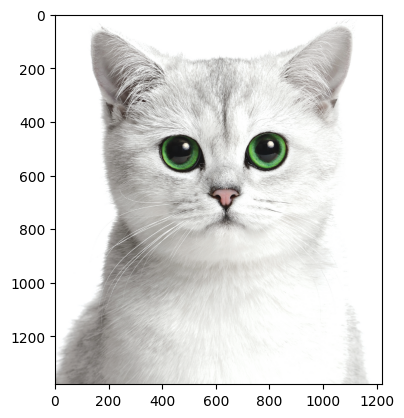

In [8]:
import matplotlib.pyplot as plt
img, label = dataset_train[0]
plt.imshow(img)
label

In [9]:
dataloader_train = create_loader(dataset_train, input_size=(3,224,224), batch_size=16, is_training=True)
dataloader_valid = create_loader(dataset_valid, input_size=(3,224,224), batch_size=8, is_training=False)

In [10]:
# 確認
for X, y in dataloader_valid:
  print(y)

tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([0], device='cuda:0')


# モデル作成

In [11]:
model = timm.create_model('resnet18', pretrained=True, num_classes=2)

# パラメータ設定

In [12]:
num_epochs = 10
device = "cuda"

# 学習

In [13]:
from tqdm import tqdm

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
loss_fn = torch.nn.CrossEntropyLoss()

model.to(device)

for epoch in range(num_epochs):
    print("EPOCH", epoch)
    model.train()
    train_loss = 0
    for batch in tqdm(dataloader_train):
        inputs, targets = batch
        outputs = model(inputs.to(device))
        loss = loss_fn(outputs, targets)
        train_loss += float(loss.detach().cpu())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    model.eval()
    eval_loss = 0
    for batch in tqdm(dataloader_valid):
        inputs, targets = batch
        with torch.no_grad() :
          outputs = model(inputs.to(device))
        loss = loss_fn(outputs, targets)
        eval_loss += float(loss.detach().cpu())
    print("train_loss = ", train_loss, "eval_loss = ", eval_loss)


EPOCH 0


 50%|█████     | 3/6 [00:05<00:04,  1.47s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 3/3 [00:02<00:00,  1.33it/s]


train_loss =  3.7021690011024475 eval_loss =  1.328833281993866
EPOCH 1


100%|██████████| 3/3 [00:01<00:00,  2.03it/s]


train_loss =  2.6844862401485443 eval_loss =  1.1234305277466774
EPOCH 2


100%|██████████| 3/3 [00:01<00:00,  2.03it/s]


train_loss =  1.6685478538274765 eval_loss =  0.46276547759771347
EPOCH 3


100%|██████████| 3/3 [00:01<00:00,  1.93it/s]


train_loss =  1.5175765454769135 eval_loss =  0.42478507850319147
EPOCH 4


100%|██████████| 3/3 [00:02<00:00,  1.40it/s]


train_loss =  1.1351660564541817 eval_loss =  0.29954907204955816
EPOCH 5


100%|██████████| 3/3 [00:01<00:00,  1.98it/s]


train_loss =  0.9558130577206612 eval_loss =  0.4198295936221257
EPOCH 6


100%|██████████| 3/3 [00:01<00:00,  2.01it/s]


train_loss =  1.1152535453438759 eval_loss =  0.4265150190331042
EPOCH 7


100%|██████████| 3/3 [00:01<00:00,  1.97it/s]


train_loss =  1.0849845856428146 eval_loss =  0.539992687816266
EPOCH 8


100%|██████████| 3/3 [00:01<00:00,  1.90it/s]


train_loss =  0.9662267416715622 eval_loss =  0.5174590736860409
EPOCH 9


100%|██████████| 3/3 [00:01<00:00,  2.01it/s]

train_loss =  0.7563037872314453 eval_loss =  0.3478970009018667


# 評価

In [14]:
model.eval()
y_pred = []
y_gt = []
for batch in tqdm(dataloader_valid):
    inputs, targets = batch
    with torch.no_grad() :
      outputs = model(inputs.to(device))
    y_gt += targets.tolist()
    y_pred += outputs.argmax(axis=1).tolist()


100%|██████████| 3/3 [00:01<00:00,  1.95it/s]


In [15]:
y_pred, y_gt

([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# 指標の計算

In [16]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

In [17]:
confusion_matrix(y_gt, y_pred)

array([[9, 0],
       [1, 7]])

In [18]:
acc, recall, prec, fs = accuracy_score(y_gt, y_pred), recall_score(y_gt, y_pred), precision_score(y_gt, y_pred), f1_score(y_gt, y_pred)
print(f"acc={acc}, recall={recall}, precition = {prec},  f-score={fs}")

acc=0.9411764705882353, recall=0.875, precition = 1.0,  f-score=0.9333333333333333


# ミス画像の表示

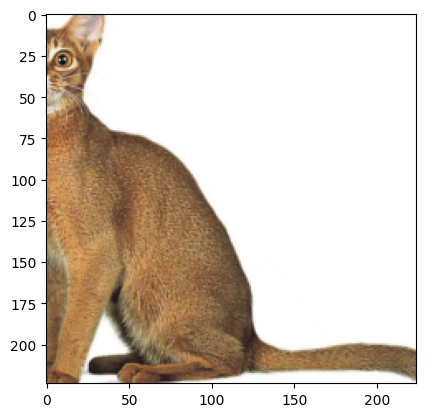

In [19]:
for idx, (x, y) in enumerate(zip(y_pred, y_gt)):
  if x != y :
    img, label = dataset_valid[idx]
    plt.imshow(img.transpose(1,2,0))
    plt.show()